In [1]:
import numpy as np, mpmath as mp, matplotlib.pyplot as plt, time, math, hashlib, csv, random
mp.dps = 50


In [2]:
# --------------- CONFIG ----------------
FIB_LEN = 1_000_000               # bits in Fibonacci mask
PRIME_CUTOFFS = [10_000_000, 25_000_000]   # prime sieves
SHIFT_MAX = 60_000
MOD_LIST = [3,5,7,9,11,13,17,19,23,29,31,37,41,43,47,53,59,61,67,71,73,79,83,89,97]
HAAR_LEVELS = 7
THETA_LIST = np.linspace(0.11,0.13,21)
TRIALS = 3
RUN_CONTROLS = True
RUN_BOOTSTRAP = True
np.random.seed(42)


In [3]:
################ Utility functions ################
def fibonacci_word(n:int):
    a,b='0','01'
    while len(b)<n:
        a,b=b,a+b
    return b[:n]

_sieve_cache={}
def primes_upto(N:int):
    if N in _sieve_cache: return _sieve_cache[N]
    sieve=bytearray(b"\x01")*(N+1)
    sieve[0:2]=b"\x00\x00"
    for p in range(2,int(N**0.5)+1):
        if sieve[p]:
            sieve[p*p:N+1:p]=b"\x00"*(((N-p*p)//p)+1)
    _sieve_cache[N]=[p for p in range(2,N+1) if sieve[p]]
    return _sieve_cache[N]

def to_bits(s:str): return np.frombuffer(s.encode(),dtype=np.uint8)-48

def autocorr(bits, shift_max):
    # never let shift exceed length‑1
    shift_max = min(shift_max, len(bits) - 1)
    n = len(bits) - shift_max
    return np.array([(bits[:n] ^ bits[k:k + n]).mean()
                     for k in range(1, shift_max + 1)])

def discrepancy(bits,primes,m):
    mask=np.zeros_like(bits); mask[[p-1 for p in primes if p<=len(bits)]]=1
    overlap=(bits & mask)
    counts=np.bincount(np.arange(len(bits))%m, weights=overlap, minlength=m)
    exp=overlap.sum()/m
    return np.abs(counts-exp)

def haar_energy(bits,level):
    w=3**level; blocks=len(bits)//w
    if blocks==0: return 0.0
    e=0.0
    for b in range(blocks):
        seg=bits[b*w:(b+1)*w]
        thirds=np.split(seg,3)
        avg=[s.mean() for s in thirds]
        e+=(avg[0]-avg[1])**2+(avg[1]-avg[2])**2+(avg[0]-avg[2])**2
    return e/blocks

def psi_weighted(theta,x,primes):
    total=0
    for p in primes:
        if p>x: break
        k=1
        while p**k<=x and k<=3:
            total+=(x//p**k)*p**k*(1-p**(-k*theta)); k+=1
    return total

# --- control sequence generators ---
def random_mask(n): return np.random.randint(0,2,size=n,dtype=np.uint8)
def wheel_mask(n):
    base=np.array(([1]+[0]*2)*11+[1]+[0],dtype=np.uint8)
    return np.tile(base, (n//34)+1)[:n]
def sturm_mask(n):
    alpha=mp.sqrt(2)-1
    return np.fromiter(((int((k+1)*alpha)%2) for k in range(n)),dtype=np.uint8,count=n)

# --- tricorn real‑axis slice ---
def tricorn_mask(n=4096,max_it=200):
    grid=np.linspace(-2,2,n)
    out=np.empty(n,dtype=np.uint8)
    for i,x in enumerate(grid):
        z=0
        for _ in range(max_it):
            z=np.conj(z)**2 + x
            if abs(z)>2:
                out[i]=1; break
        else:
            out[i]=0
    return out


In [4]:
################ Metrics suite ################
def theta_curve(bits,primes):
    arr=[]
    for θ in THETA_LIST:
        bias=np.mean([psi_weighted(θ,x,primes)-x for x in (1_000_000,2_000_000,5_000_000)])
        arr.append(np.mean([abs(psi_weighted(θ,x,primes)-x-bias) for x in (1_000_000,2_000_000,5_000_000)]))
    return np.array(arr)

def analyse_mask(bits,label,primes,writer):
    # autocorr
    ac=autocorr(bits,SHIFT_MAX); dip,shift=ac.min(),ac.argmin()+1
    # Haar energies
    energies=[haar_energy(bits,l) for l in range(1,HAAR_LEVELS+1)]
    # discrepancy peaks & φ‑slope
    peaks=np.array([discrepancy(bits,primes,m).max() for m in MOD_LIST])
    slope,_=np.polyfit(MOD_LIST, np.log(peaks+1e-9),1)
    # θ scan
    tc=theta_curve(bits,primes); θ_star=THETA_LIST[int(tc.argmin())]
    # plot summaries
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.plot(ac); plt.title(f"Autocorr {label}\nmin @ {shift}")
    plt.subplot(1,3,2); plt.semilogy(range(1,HAAR_LEVELS+1),energies,'o-'); plt.title("Haar decay")
    plt.subplot(1,3,3); plt.plot(THETA_LIST,tc); plt.axvline(θ_star,ls='--'); plt.title(f"θ*={θ_star:.3f}")
    plt.tight_layout(); plt.show()
    # write CSV
    writer.writerow([label,shift,dip,θ_star,energies[0],slope])
    print(f"{label}: shift {shift} dip {dip:.2e} θ* {θ_star:.3f} φ‑slope {slope:.3f}")


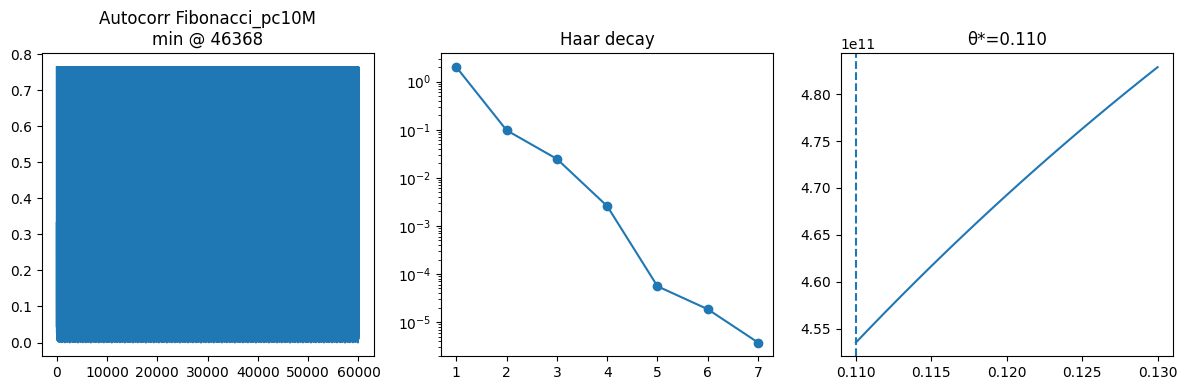

Fibonacci_pc10M: shift 46368 dip 1.91e-05 θ* 0.110 φ‑slope -0.031


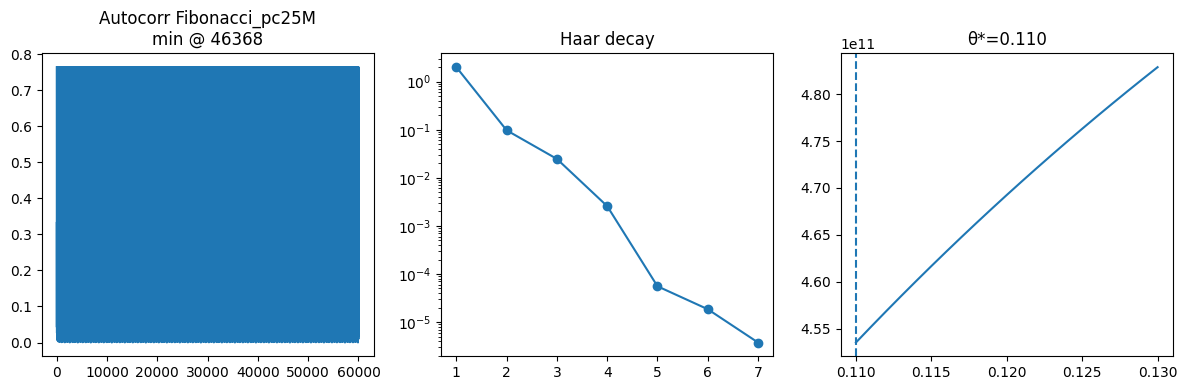

Fibonacci_pc25M: shift 46368 dip 1.91e-05 θ* 0.110 φ‑slope -0.031


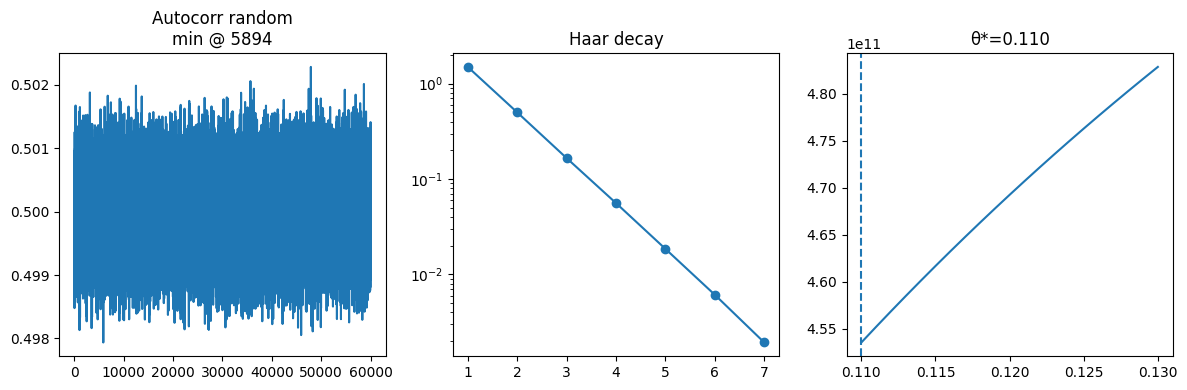

random: shift 5894 dip 4.98e-01 θ* 0.110 φ‑slope -0.031


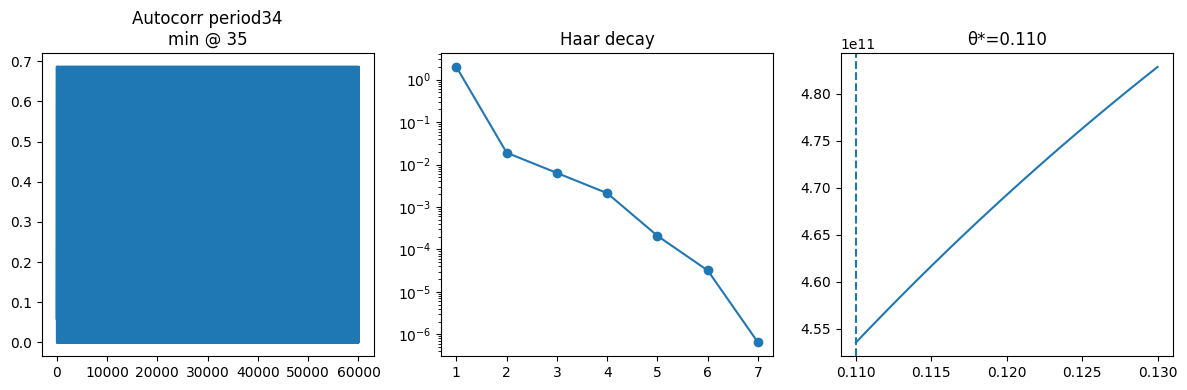

period34: shift 35 dip 0.00e+00 θ* 0.110 φ‑slope -0.031


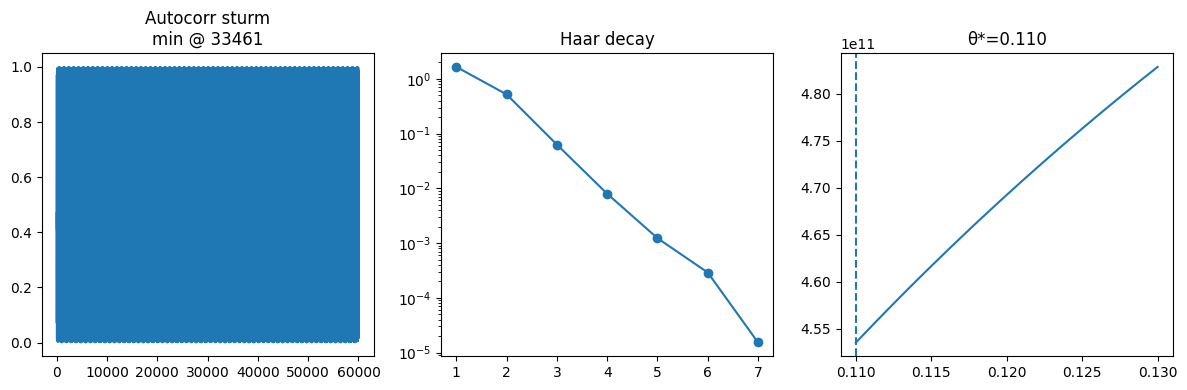

sturm: shift 33461 dip 9.57e-06 θ* 0.110 φ‑slope -0.031


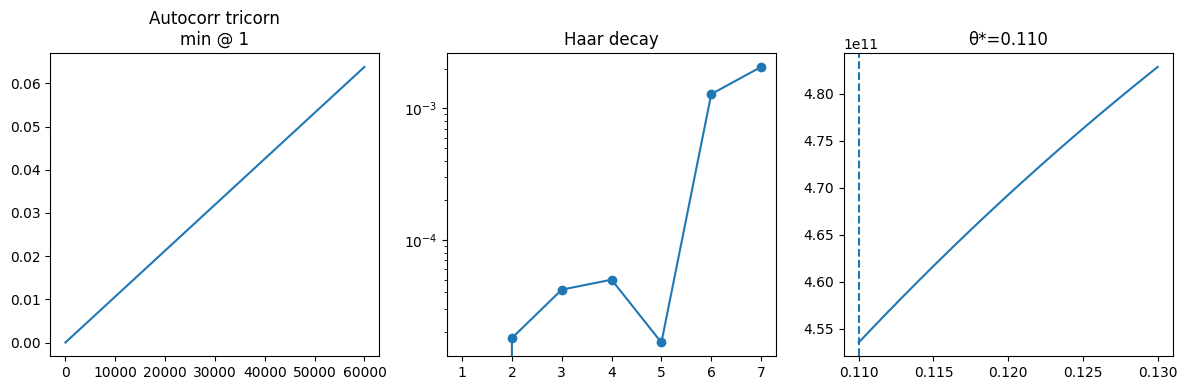

tricorn: shift 1 dip 1.06e-06 θ* 0.110 φ‑slope -0.031
Bootstrap p‑value (Haar lvl1) = 1.0
CSV saved to /content/fib_thread_results.csv


In [5]:
################ Main driver ################
def main():
    csv_path='/content/fib_thread_results.csv'
    with open(csv_path,'w',newline='') as f:
        writer=csv.writer(f)
        writer.writerow(["label","shift","dip","theta_star","haar_lvl1","phi_slope"])

        fib_bits=to_bits(fibonacci_word(FIB_LEN))
        for pc in PRIME_CUTOFFS:
            primes=primes_upto(pc)
            analyse_mask(fib_bits, f"Fibonacci_pc{pc//1_000_000}M", primes, writer)

        if RUN_CONTROLS:
            n=len(fib_bits); primes=primes_upto(PRIME_CUTOFFS[0])
            analyse_mask(random_mask(n),"random",primes,writer)
            analyse_mask(wheel_mask(n),"period34",primes,writer)
            analyse_mask(sturm_mask(n),"sturm",primes,writer)
            # The original tricorn analysis was outside the main function; corrected and included here.
            tri_bits = tricorn_mask(len(fib_bits))    # match Fibonacci length
            analyse_mask(tri_bits, "tricorn", primes, writer)


        if RUN_BOOTSTRAP:
            base=haar_energy(fib_bits,1)
            rand=[haar_energy(random_mask(len(fib_bits)),1) for _ in range(100)]
            p=(np.sum(np.array(rand)<=base)+1)/101
            print("Bootstrap p‑value (Haar lvl1) =",p)

    print("CSV saved to",csv_path)

main()

In [6]:
print('Fingerprint', hashlib.sha256(b'FibMega_v5_full').hexdigest()[:16])

Fingerprint dff19771095782ff
